### Here we study the photometry noise based on the NSA catalog (from Chang's SEDflow)

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import torch
import corner
import os

In [6]:
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')

In [8]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.utils import flux2mag, mag2flux, sigma_flux2mag, sigma_mag2flux

In [19]:
mags_nsa = np.load('./nsa_sedflow/nsa_mag_data.npy').T
sigs_nsa = np.load('./nsa_sedflow/nsa_mag_err_data.npy').T

In [20]:
flux_nsa = mag2flux(mags_nsa)
ivar_nsa = sigma_mag2flux(sigs_nsa, mags_nsa)
snrs_nsa = flux_nsa / ivar_nsa

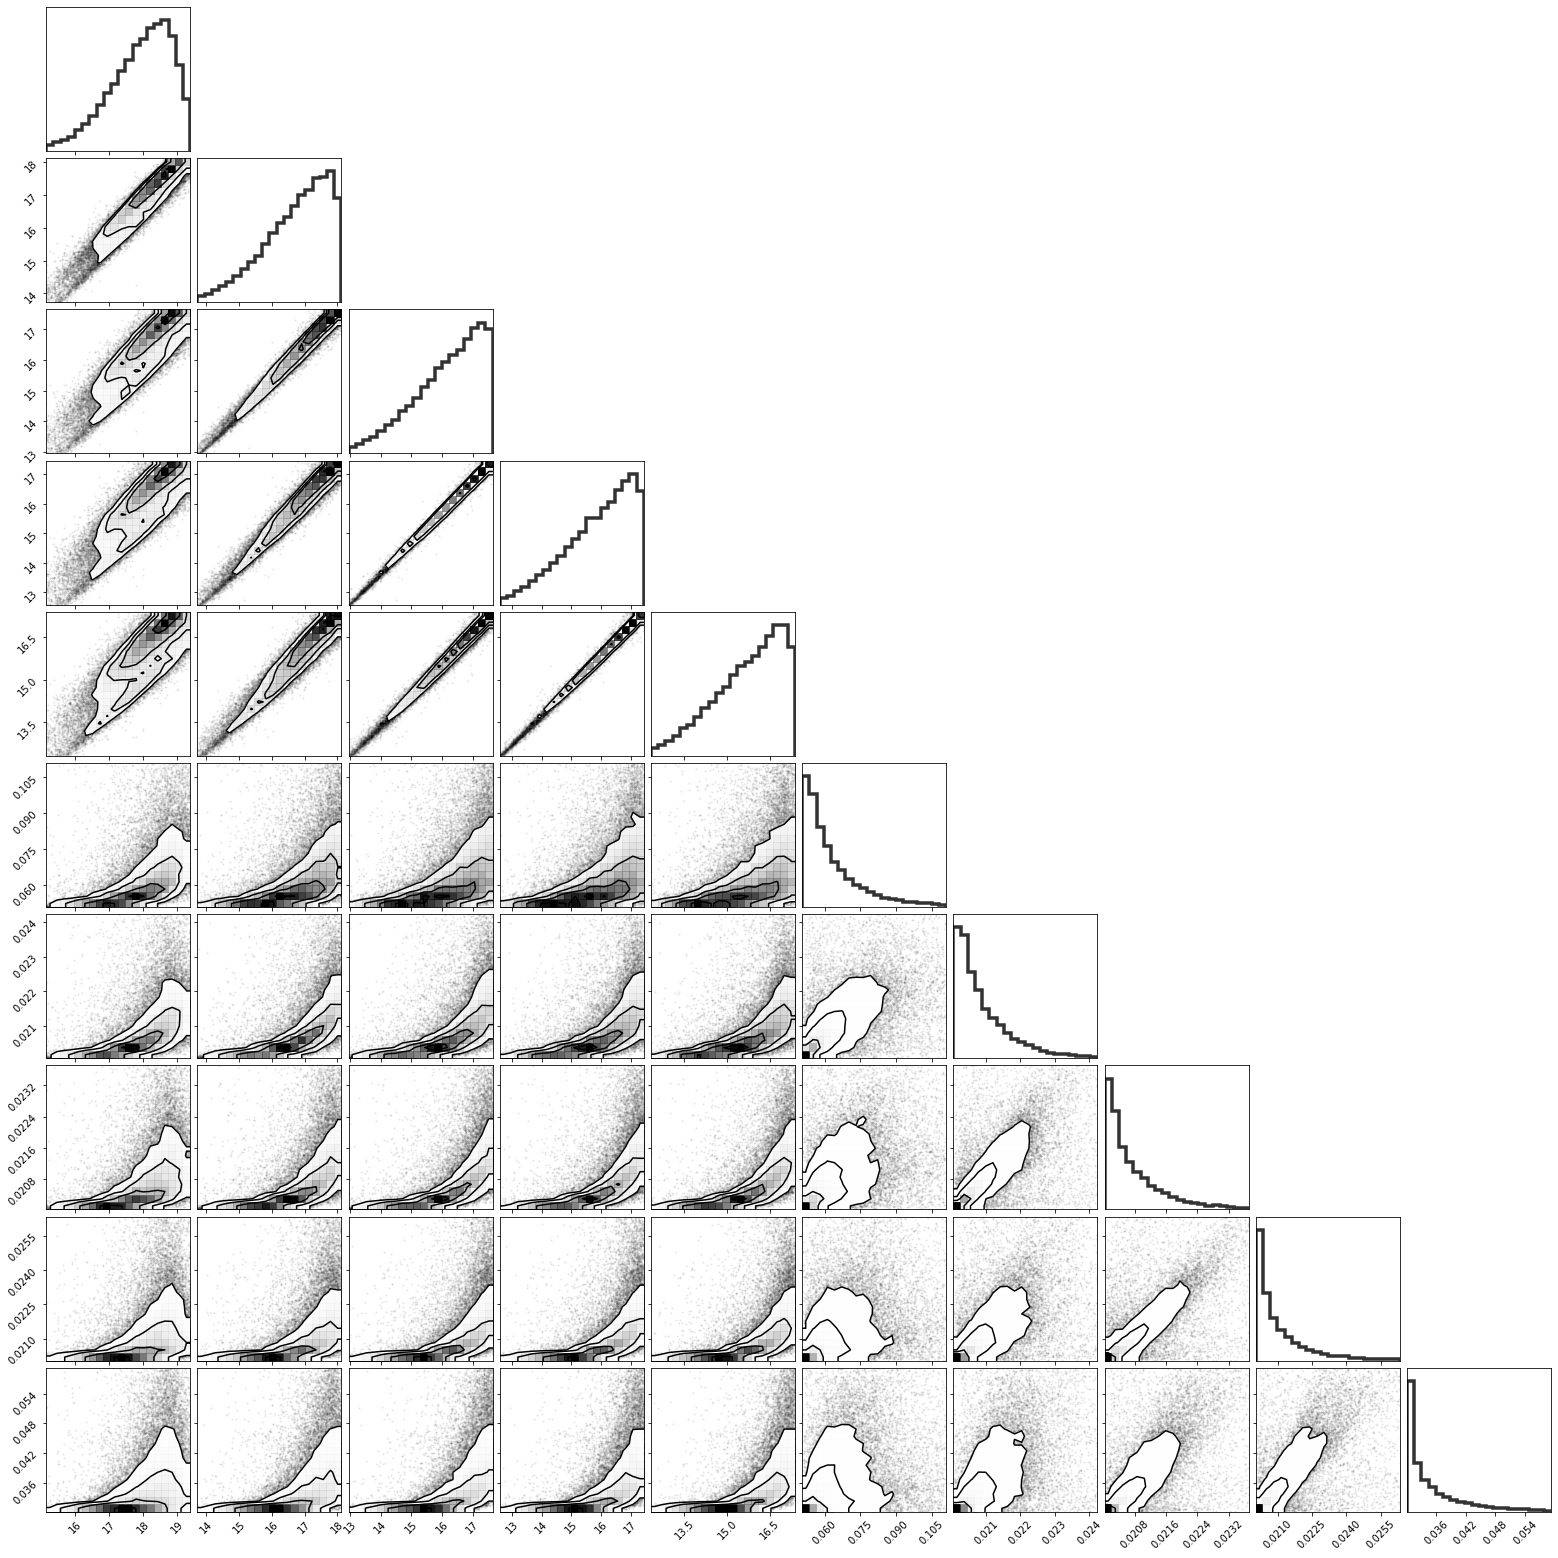

In [27]:
fig = corner.corner(np.concatenate([mags_nsa, sigs_nsa], axis=1), 
                    range=np.nanquantile(
                     np.concatenate([mags_nsa, sigs_nsa], axis=1), 
                     [0.01, 0.95], axis=0).T)

In [28]:
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

In [29]:
def trimmed_median(x): 
    xlim = np.quantile(x, [0.0, 0.9])
    return np.median(x[(x > xlim[0]) & (x < xlim[1])])

def trimmed_std(x): 
    xlim = np.quantile(x, [0.0, 0.9])
    return np.std(x[(x > xlim[0]) & (x < xlim[1])])

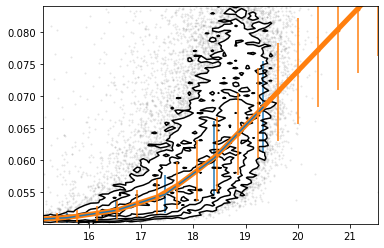

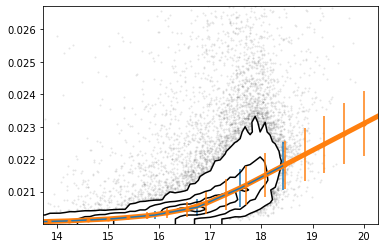

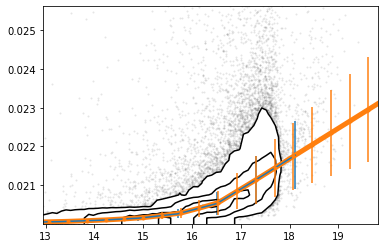

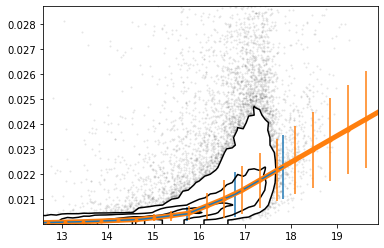

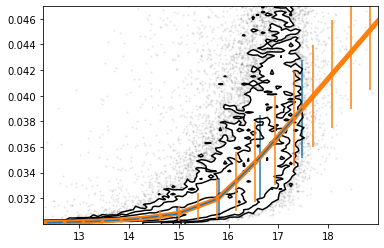

In [30]:
meds_sigs, stds_sigs = [], [] 

for i in range(5): 
    clean = (np.isfinite(mags_nsa[:,i]) & (sigs_nsa[:,i] < np.max([np.quantile(sigs_nsa[:,i], 0.9), 0.05])))

    med_sig, mags_edges, _ = binned_statistic(mags_nsa[clean,i], sigs_nsa[clean,i], statistic=trimmed_median, range=np.nanquantile(mags_nsa[clean,i], [0., 0.995]), bins=10)
    std_sig, mags_edges, _ = binned_statistic(mags_nsa[clean,i], sigs_nsa[clean,i], statistic=trimmed_std, range=np.nanquantile(mags_nsa[clean,i], [0., 0.995]), bins=10)
    
    finite = (np.isfinite(med_sig) & np.isfinite(std_sig))
    meds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], med_sig[finite], fill_value='extrapolate'))
    stds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], std_sig[finite], fill_value='extrapolate'))
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    sub.plot(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig, c='C0')
    sub.errorbar(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig,
                 yerr=std_sig, c='C0')
    corner.hist2d(mags_nsa[clean,i], sigs_nsa[clean,i], plot_density=False, bins=100, ax=sub)
    
    sub.plot(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), c='C1', lw=5)
    sub.errorbar(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), 
                 yerr=stds_sigs[-1](np.linspace(10, 25, 40)), fmt='.C1')
    sub.set_xlim(np.nanquantile(mags_nsa[clean,i], [0.01, 1.]))
    sub.set_ylim(np.nanquantile(sigs_nsa[clean,i], [0.0, 0.975]))

In [31]:
np.save('./noise_model/nsa_noise_model_mag_chang.npy', np.vstack([meds_sigs, stds_sigs]))